In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import nltk 

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

pio.renderers.default = 'iframe'
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_colwidth', None)
sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KornkamolSampaongern\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
categories = ['project_proponent','ghg_emission_reduction','crediting_period','sector','methodology','project_location']

#### Functions

In [3]:
def _plot_pie_chart(df, group='', count='', topn=None):
    # To visualize the distribution using pie chart

    # Group the data, count values, and sort in order
    status_counts = df.groupby(group)[count].nunique().sort_values(ascending=False)[:topn]

    # Filter out categories with less than 1% of the total count
    status_counts = status_counts[status_counts/status_counts.sum()>=0.01]

    # Create a pie chart
    fig = px.pie(
        names=status_counts.index, 
        values=status_counts.values, 
        color_discrete_sequence=px.colors.diverging.BrBG)
    
    fig.show()

In [4]:
def _plot_histogram(df, value='', x_title='', y_title=''):
    # To visualize the distribution using histogram

    # Create a histogram
    fig = px.histogram(
        df,
        x=value,
        color_discrete_sequence=['#43A094'])

    # Set axis's title
    fig.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        bargap=0.2)
    
    fig.show()

In [5]:
def _plot_stacked_barv_chart(df, hue='', x_value='', y_value='', color=None):
    # To visualize the distribution using vertical stacked bar chart

    # Create a vertical stacked bar chart
    fig = px.bar(
        df,
        x=x_value,
        y=y_value,
        color=hue,
        color_discrete_sequence=color)
    
    fig.show()

In [6]:
def _plot_stacked_bar_chart(df, hue='', x_value='', y_value=''):
    # To visualize the distribution using horizontal stacked bar chart

    # Create a horizontal stacked bar chart
    fig = px.bar(
        df,
        x=x_value,
        y=y_value,
        color=hue,
        color_discrete_sequence=px.colors.diverging.BrBG,
        orientation='h',
        text='percentage')

    # Set template of value showing inside bar chart
    fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside')

    # Set font size
    fig.update_layout(font={'size': 18})
    
    fig.show()

In [7]:
def _generate_dist_plot(data, category, value, color=''):
    # To visualize the distribution using distribution plot

    # Get unique category name
    category_names = data[category].unique()

    # Extract the value column for each category
    data = [data[data[category] == cat][value] for cat in category_names]

    # Create a dist plot
    fig = ff.create_distplot(
        data, 
        category_names, 
        colors = color,
        bin_size=.2)

    # Set figure's configuration
    fig.update_layout(
        xaxis_title=value,
        yaxis_title='Density',
        font={'size': 14})
    
    fig.show()

In [8]:
def _plot_kde(df, x_value, hue, title):
    # To visualise KDE plot
    
    plt.figure(figsize=(12, 6))

    # Generate KDE Plot
    sns.kdeplot(data=df, x=x_value, hue=hue, fill=True, common_norm=False, palette='coolwarm', alpha=0.3, warn_singular=False)

    # Set visualisation's configuration
    plt.title(title, fontsize=16)
    plt.xlabel('Number of Sections', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    
    plt.tight_layout()
    plt.show()

In [9]:
def _generate_ngrams(words, n=2):
    # To generate n-grams from words
    
    # Create a CountVectorizer to generate n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(words)

    # Combine n-grams and frequencies, and sort by frequency
    list = sorted(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)), key=lambda x: x[1], reverse=True)
    
    return list

In [10]:
def _plot_ngram_frequencies(list, n=5, title=''):
    # To visualise n-grams frequency using bar chart

    # Create a horizontal bar chart to visualize n-gram frequencies
    ngrams, frequency = zip(*list[:n])
    plt.figure(figsize=(10,6))
    plt.barh(ngrams, frequency, color='lightsteelblue')

    # Set label and title
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=12)      
    plt.title(title)
    
    plt.gca().invert_yaxis()
    plt.show()

In [11]:
def _create_wordcloud(ngrams):
    # To visualise n-grams and frequencies using wordcloud

    # Create wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='ocean',max_words=30).generate_from_frequencies(dict(ngrams))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [12]:
def _coverage_assessment(df, headings):
    # Assess whether keywords are enough to cover most variants of headings in the dataset

    # Get the total number of unique projects
    total_project = df.id.nunique()
    result = []
    filtered_dfs = pd.DataFrame()

    # Loop through variant of each headings' keywords
    for topic in headings:
        variants = headings[topic]
        for variant in variants:

            # Append rows where the heading can be covered using predefined keywords
            df_filtered = df[df['section'].str.contains(re.escape(variant), case=False)]
            df_filtered['topic'] = topic
            filtered_dfs = pd.concat([filtered_dfs, df_filtered], ignore_index=True)

        # Count the number of unique projects that can be covered by the heading variants
        ids = filtered_dfs[filtered_dfs['topic']==topic].id.nunique()
        result.append({topic: round(ids/total_project,2)})
    
    return result

In [13]:
def _map_alphabet_to_digit(value):
    # To convert letter to number to perform analysis

    mapping_dict = {chr(i): i - 64 for i in range(65, 91)}
    
    # Convert only alphabetic characters, otherwise remain unchanged
    if isinstance(value, str) and value.isalpha():
        return mapping_dict.get(value, value)
        
    return value

In [14]:
def _assign_section_key(row, final_variants):
    # To map headings to section using keyword search

    # Iterate search for keywords in each heading, then assign to each section
    for key, variants in final_variants.items():
        if any(row['heading'].lower().strip().find(variant.lower()) != -1 for variant in variants):
            return key
    return None

In [15]:
def _extract_section_number_from_heading(df):
    # To extract main heading number and heading name

    # look for pattern (digit)(dot)(digit)
    df['heading_number'] = df['heading'].str.extract(r'(\d+\.\d+)')

    # look for the text after pattern (digit)(dot)(digit)
    df['heading_name'] = df['heading'].str.extract(r'\d+\.\d+\s+(.*)')

    # Get the first digit from heading
    df['section'] = df['heading_number'].str.split('.').str[0]

    return df

## Analysis for Identifying Predefined Keywords to Determine Heading Relevance

### 1. Use GPT to map section content to category on 338 sample projects

In [16]:
llm_category_mapping_using_content = pd.read_csv('../../data/training/data_analysis/result_section_mapping_using_llm.csv')

In [17]:
llm_category_mapping_using_content_agg = llm_category_mapping_using_content.groupby(['id','heading_name']).agg({'mapped_categories':', '.join}).reset_index()

In [18]:
llm_category_mapping_using_content_agg['mapped_categories_len'] = llm_category_mapping_using_content_agg['mapped_categories'].str.len()
llm_category_mapping_using_content_agg = llm_category_mapping_using_content_agg.sort_values(by='mapped_categories_len', ascending=False)

In [19]:
llm_category_mapping_using_content_agg[['heading_name', 'mapped_categories']]

,heading_name,mapped_categories
212,1.12.4 Participation under Other GHG Programs,"project_title, other_entities, project_proponent, project_start_date, project_summary, leakage_analysis, ghg_emission_reduction, date_issue_of_project, standard, project_size, project_location, project_country, version_of_file, expected_first_vintage_of_credit_issuance, additional_analysis, project_lifetime, baseline_analysis, natural_catastrophe_climate_change"
374,2.4.7 Commercially Sensitive Information (Rules 3.5.13 – 3.5.14),"project_title, other_entities, project_proponent, project_start_date, project_summary, leakage_analysis, ghg_emission_reduction, date_issue_of_project, standard, project_size, project_location, project_country, version_of_file, expected_first_vintage_of_credit_issuance, additional_analysis, project_lifetime, baseline_analysis, natural_catastrophe_climate_change"
213,1.12.5 Projects Rejected by Other GHG Programs,"project_title, other_entities, project_proponent, project_start_date, project_summary, leakage_analysis, ghg_emission_reduction, date_issue_of_project, standard, project_size, project_location, project_country, version_of_file, expected_first_vintage_of_credit_issuance, additional_analysis, project_lifetime, baseline_analysis, natural_catastrophe_climate_change"
41,1.12. Other Forms of Environmental Credit:,"project_title, other_entities, project_proponent, project_start_date, project_summary, leakage_analysis, ghg_emission_reduction, date_issue_of_project, standard, project_size, project_location, project_country, version_of_file, expected_first_vintage_of_credit_issuance, additional_analysis, project_lifetime, baseline_analysis, natural_catastrophe_climate_change"
250,1.15.2 ProjectsRejectedby Other GHGPrograms,"project_title, other_entities, project_proponent, project_start_date, project_summary, leakage_analysis, ghg_emission_reduction, date_issue_of_project, standard, project_size, project_location, project_country, version_of_file, expected_first_vintage_of_credit_issuance, additional_analysis, project_lifetime, baseline_analysis, natural_catastrophe_climate_change"
...,...,...
446,Calibration,standard
28,"Project technologies, products, services and the expected",standard
179,Title and reference of the VCS methodology applied to,standard
479,"Compliance with Laws, Statutes and Other Regulatory Frameworks",standard


The current mapping results are not accurate, with each heading being associated with nearly all categories. This issue arises from keyword occurrences in the content or potential model hallucinations. Moreover, the model generates categories beyond those explicitly requested.

### 2. Use GPT to map heading to category on 338 sample projects

In [20]:
llm_category_mapping_using_heading = pd.read_csv('../../data/training/data_analysis/result_heading_mapping_using_llm.csv')
scraped_df = pd.read_csv('../../data/training/data_collection/verra_data.csv')

In [21]:
llm_category_mapping_using_heading = pd.merge(llm_category_mapping_using_heading, scraped_df, on=['id','filename'])

In [22]:
country_mapping = {
    "Rio Grande do Sul and Santa Catarina": "Brazil",
    "Sichuan Province": "China",
    "Gansu": "China",
    "Guizhou": "China",
    "Mato Grosso do Sul": "Brazil",
    "Regions RM, V, VI, VII, VIII": "Chile",
    "Pernambuco": "Brazil",
    "Guizhou Province": "China",
    "PA": "Brazil",
    "Henan Province": "China",
    "Jaisalmer district in Rajasthan": "India",
    "Madre de Dios": "Peru",
    "Karnataka": "India",
    "Department Francisco Morazán": "Honduras",
    "Pará": "Brazil",
    "Southern Atlantic Autonomous Region (RAAS)": "Nicaragua",
    "Pará state": "Brazil",
    "Hebei Province": "China",
    "Songyuan City, Jilin Province": "China",
    "Jilin": "China",
    "San Paulo": "Brazil",
    "Eastern Mediterranean Region": "Turkey",
    "Nakhorn Ratchasima Province": "Thailand",
    "Rio de Janeiro": "Brazil",
    "Beijing": "China",
    "southern bank of the Valparaiso River": "Argentina",
    "northern bank of the Valparaiso River": "Argentina",
    "Amapá": "Brazil",
    "Himachal Pradesh": "India",
    "Brazilian Amazon": "Brazil",
    "Gorno-Badakhshan Autonomous Oblast (GBAO)": "Tajikistan",
    "East Sepik province": "Papua New Guinea",
    "Peruvian Amazon Basin": "Peru",
    "Chungchongnam-do": "South Korea",
    "Amazonas State": "Brazil",
    "Uttar Pradesh": "India",
    "MA": "United States",
    "Jiangxi": "China",
    "Tamil nadu": "India",
    "West Java Province": "Indonesia",
    "Region XIV": "Chile",
    "Uttaranchal": "India",
    "Elazığ and Tunceli Provinces": "Turkey",
    "Eastern and Southern Provinces": "Zambia",
    "Lusaka": "Zambia",
    "Jurisdictions of Elazığ and Tunceli Provinces": "Turkey",
    "Tucumán": "Argentina",
    "Yunnan": "China",
    "Liaoning province": "China",
    "Sindh": "Pakistan",
    "Nyanza and Western provinces": "Kenya",
    "State of Para, micro region of Porte": "Brazil",
    "Colombian Orinoco": "Colombia",
    "Gujarat": "India",
    "Tahuamanu": "Peru",
    "Andhra Pradesh": "India",
    "New Ireland and East New Britain Province": "Papua New Guinea",
    "Tamilnadu": "India",
    "District: Mohali": "India",
    "Shandong Province": "China",
    "Guangxi Zhuang Autonomous Region": "China",
    "Toamasina Province": "Madagascar",
    "OK": "United States",
    "Multiple States/Provinces": "Various",
    "Kutch, Gujarat": "India",
    "Casamance": "Senegal",
    "Lindi": "Tanzania",
    "Para State": "Brazil",
    "Hubei Province": "China",
    "San Pedro, Canindeyu": "Paraguay",
    "Anhui Province": "China",
    "Oromia Regional State": "Ethiopia",
    "IL": "United States",
    "Gansu Province": "China",
    "Tamilnadu & Karnataka": "India",
    "Jilin Province": "China",
    "Jiangsu Province": "China",
    "Orientale Province": "DR Congo",
    "Ucayali": "Peru",
    "Guangxi": "China",
    "Tonkolili and Port Loko Districts": "Sierra Leone",
    "Caldas": "Colombia",
    "Odisha, Andhra Pradesh and Chhattisgarh": "India",
    "Acre": "Brazil",
    "Ashanti": "Ghana",
    "KY": "United States",
    "Nariño": "Colombia",
    "Chocó": "Colombia",
    "Santa Catarina": "Brazil",
    "Peten": "Guatemala",
    "Inner Mongolia Autonomous Region": "China",
    "Central East region": "Brazil",
    "Eastern & Uva Provinces": "Sri Lanka",
    "Department of Vichada": "Colombia",
    "Izabal": "Guatemala",
    "Bursa Province": "Turkey",
    "Rajasthan": "India",
    "Taiba Ndiaye": "Senegal",
    "Zhejiang Province": "China",
    "state of Rondônia": "Brazil",
    "Madhya Pradesh": "India",
    "Yong’an City, Fujian Province": "China",
    "Punjab Andhra Pradesh & others": "India",
    "NE states": "India",
    "Coast": "Kenya",
    "Presidente Hayes Department": "Paraguay",
    "Antioquia and Arauca": "Colombia",
    "Chongqing": "China",
    "Chhattisgarh": "India",
    "Eastern provinces": "Sierra Leone",
    "District: Siddipet, State: Telangana": "India",
    "BC": "Canada",
    "Coast Province": "Kenya",
    "Punjab": "India",
    "MI": "United States",
    "Mondulkiri": "Cambodia",
    "State: Amazonas": "Brazil",
    "VA": "United States",
    "NSW": "Australia",
    "Fujian Province": "China",
    "Toledo District": "Belize",
    "Acre and Amazonas": "Brazil",
    "State of Mato Grosso": "Brazil",
    "Karnataka, Tamil Nadu": "India",
    "Sabah": "Malaysia",
    "Kabarole": "Uganda",
    "Central Kalimantan": "Indonesia",
    "Guangxi Province": "China",
    "Chattishgarh": "India",
    "Inner Mongolia Autonomous": "China",
    "Inner Mongolia Autonomous Region": "China",
    "Guatemala COUNTRY-WIDE": "Guatemala",
    "Multi State": "Various",
    "Haryana": "India",
    "Chitradurga District of Karnataka": "India",
    "ÇANKIRI": "Turkey",
    "Tabasco": "Mexico",
    "Guangdong Province": "China",
    "Koh Kong Province": "Cambodia",
    "Kabupaten Batubara, Sumetera Utara": "Indonesia",
    "Jamnagar and Rajkot districts": "India",
    "Central, Rift Valley and Eastern Provinces": "Kenya",
    "ND": "United States",
    "Telangana, Gujarat, Rajasthan": "India",
    "Telangana,": "India",
    "Eastern and Lusaka Province": "Zambia",
    "Rize": "Turkey",
    "SD": "United States",
    "Sikkim state": "India",
    "Andhra Pradesh, Rajasthan, Karnataka": "India",
    "Shanxi Province": "China",
    "Sine Saloum and Casamance": "Senegal",
    "Shenzhen City, Guangdong Province": "China",
    "Multiple State": "Various",
    "San Martin": "Peru",
    "Eastern Uganda": "Uganda",
    "Qinghai": "China",
    "Odisha": "India",
    "Multiple States": "Various",
    "Rondônia and Amazonas": "Brazil",
    "Pará State, Eastern Amazon": "Brazil",
    "XinJiang": "China",
    "Ningxia Autonomous Region, P. R. China": "China",
    "Orange Walk": "Belize",
    "Department of Chocó and the Municipality of Acandí": "Colombia",
    "Mariscal Cáceres and Huallaga Provinces": "Peru",
    "Telengana and Maharashtra": "India",
    "Department of Madre de Dios": "Peru",
    "AK": "United States",
    "Hunan Province": "China",
    "Tanganyika District": "Tanzania",
    "Mato Grosso": "Brazil",
    "South Sumatra Province": "Indonesia",
    "Kiteto District": "Tanzania",
    "State of Bahia": "Brazil",
    "Choco": "Colombia",
    "Valle": "Colombia",
    "Valle de Cauca": "Colombia",
    "Antioquia and Choco": "Colombia",
    "Department of Cauca": "Colombia",
    "Inner Mongolia Autonomous": "China",
    "Chengde City, Hebei Province": "China",
    "Makueni, Taita Taveta, and Kajiado Counties": "Kenya",
    "Matabeleland North, Midlands, Mashonaland West, and Mashonaland Central": "Zimbabwe",
    "Hebei": "China",
    "Uttar Pradesh, Telangana, Andhra Pradesh, Gujarat": "India",
    "Inner Mongolia": "China",
    "Jammu & Kashmir": "India",
    "Saraburi, Lampang,  Nakon Si Thammarat": "Thailand",
    "Nakhon Ratchasima": "Thailand",
    "Para": "Brazil",
    "Mai Ndombe": "DR Congo",
    "Sichuan": "China",
    "Maharashtra": "India",
    "Rajasthan, Gujarat, Karnataka, Tamil Nadu, Ma": "India",
    "Dhaka": "Bangladesh",
    "SC": "United States",
    "Chongqing, Yunnan, Sichuan and Guizhou Province": "China",
    "West Bengal": "India",
    "San Martin province": "Peru",
    "Cerro Chato/ Valentines and Regis/ Garao Regions": "Uruguay",
    "Cerro Largo and Treinta y Tres": "Uruguay",
    "Amazonas": "Brazil",
    "San Juan": "Argentina",
    "Vichada": "Colombia",
    "Jiangsu": "China",
    "TX": "United States",
    "Para, micro region of Portel": "Brazil",
    "East Godavari District, Andhra Pradesh": "India",
    "Aceh and North Sumatra provinces": "Indonesia",
    "San Martin and Amazonas": "Peru",
    "Multiple": "Various",
    "Rayong": "Thailand",
    "municipalities of Machadinho d’Oeste and Cujubim": "Brazil",
    "South-Western and South-Eastern provinces": "Uganda",
    "Bengkulu": "Indonesia",
    "North Sumatra Province": "Indonesia",
    "Free State and Mpumalanga provinces": "South Africa",
    "District of Kullu of Himachal Pradesh": "India",
    "Tamil Nadu, Karnataka, Andhra Pradesh": "India",
    "Tuyen Quang Province": "Vietnam",
    "Rio de Janiero": "Brazil",
    "Ordu Province": "Turkey",
    "Eastern Province": "Zambia"
}

country_df = pd.DataFrame(list(country_mapping.items()), columns=['State/Province', 'Country'])

In [23]:
llm_category_mapping_using_heading  = pd.merge(llm_category_mapping_using_heading , country_df, on='State/Province', how='left')

In [24]:
# Extract section number and name from heading
llm_category_mapping_using_heading = _extract_section_number_from_heading(llm_category_mapping_using_heading)

In [25]:
# Filter rows only focusing category
filtered_df = llm_category_mapping_using_heading[llm_category_mapping_using_heading['category'].isin(categories)]

# Group data by category, and count number of unique project
agg_data = filtered_df.groupby(['category', 'section'])['id'].nunique().unstack(fill_value=0)

# Calculate percentage of each section within each category
data = agg_data.div(agg_data.sum(axis=1), axis=0) * 100

# Reshape data
data = data.reset_index().melt(id_vars='category', var_name='section', value_name='percentage')

# Plot the stacked bar chart
_plot_stacked_bar_chart(data, hue='section', x_value='percentage', y_value='category')

### 3. Analysis on headings across all 2,500 projects

In [26]:
toc = pd.read_csv('../../data/training/data_analysis/table_of_contents.csv')

In [27]:
# Extract section name and number from headings
toc['heading'] = toc['section']
toc['next_section_page'] = toc['end_page'].astype(int)
toc['section_number'] = toc['section'].str.split(' ', n=1).str[0]
toc['section'] = toc['section_number'].str.split('.', n=1).str[0]
toc['original_section'] = toc['section']

In [28]:
project_sector = pd.read_csv('../../data/training/data_collection/AlliedOffsets_project_info.csv', dtype='str')

# Filter only focusing area from VCS and project sectors in forestry and energy
project_sector = project_sector[(project_sector['UID'].str.startswith('VCS'))&
                (project_sector['Project Sector'].isin(['Forestry and Land Use', 'Renewable Energy']))]

# Extract only ID number from UID
project_sector['id'] = project_sector['UID'].str.split('VCS', n=1).str[1].astype('int64')
project_sector = project_sector[['id','Registry','Project Sector','Project Country','Project Methodologies','Project Region','Project Continent', 'Year Founded']]

In [29]:
toc = toc.merge(project_sector, how='left', on='id')
toc = toc.merge(scraped_df, how='left', on='id')

In [30]:
# Extract project registration year from date
toc['Project Registration Date'] = pd.to_datetime(toc['Project Registration Date'], errors='coerce', dayfirst=True)
toc['Project Registration Year'] = toc['Project Registration Date'].dt.to_period('Y').astype(str)
toc['Project Registration Year'] = toc['Project Registration Year'].replace('NaT', pd.NA)

# Use data from AlliedOffsets to fill empty value of project regirstration year
toc['Year Founded'] = toc['Year Founded'].astype(str).str.split('-').str[0].str.replace(',', '')
toc['Project Registration Year'] = toc['Project Registration Year'].fillna(toc['Year Founded'])

In [31]:
toc['section'] = toc['section'].apply(_map_alphabet_to_digit)
toc['section'] = toc['section'].astype('int')

In [32]:
# Get start, end page, and number of section for each project
stats = toc.groupby('id').agg(min_page=('start_page', 'min'),
                              max_page=('start_page', 'max'),
                              number_of_sections=('section', 'max'))

# Get total number of pages for each project
stats['page_number'] = stats['max_page']-stats['min_page']

In [33]:
toc = toc.merge(stats, how='left', right_on='id', left_on='id')

In [34]:
toc = toc[toc['VCS Project Type'].isin(['Agriculture Forestry and Other Land Use', 'Energy industries (renewable/non-renewable sources)'])]

In [35]:
toc_project_level = toc[['id', 'Project Sector', 'Project Country',
                         'Project Methodologies', 'Project Region', 'Project Continent',
                         'number_of_sections', 'page_number','VCS Project Status', 'VCS Project Type','Project Registration Year']].drop_duplicates()

In [36]:
_plot_pie_chart(toc_project_level, group='VCS Project Status', count='id')

In [37]:
_plot_pie_chart(toc_project_level, group='VCS Project Type', count='id')

In [38]:
_plot_pie_chart(toc_project_level, group='Project Country', count='id', topn=15)

In [39]:
_plot_pie_chart(toc_project_level, group='Project Registration Year', count='id')

In [40]:
toc_project_level['Project Registration Year'] = pd.to_numeric(toc_project_level['Project Registration Year'],errors='coerce')
_plot_histogram(toc_project_level, value='Project Registration Year', x_title='Project Registration Year', y_title='Project Count')

In [41]:
toc_project_level['Number of Sections'] = toc_project_level['number_of_sections'].astype('int')

In [42]:
_generate_dist_plot(toc_project_level, 'Project Sector', 'Number of Sections', color=['#44545a', '#43A094'])

In [43]:
toc_project_level['Number of Pages'] = toc_project_level['page_number'].astype('int')
_generate_dist_plot(toc_project_level, 'Project Sector', 'Number of Pages', color=['#44545a', '#43A094'])

In [44]:
df_counts = toc_project_level.groupby(['Project Registration Year', 'Project Sector'])['id'].nunique().reset_index()
df_counts.columns = ['Project Registration Year', 'Project Sector', 'Project Count']

_plot_stacked_barv_chart(df_counts, hue='Project Sector', x_value='Project Registration Year', y_value='Project Count', color=['#44545a', '#43A094'])

Forestry and Land Use projects tend to have more sections and pages in their PDDS.

In [45]:
filtered = toc_project_level[~toc_project_level['Project Region'].isna()]

In [46]:
_generate_dist_plot(filtered, 'Project Region', 'Number of Pages')

In [47]:
_generate_dist_plot(filtered, 'Project Region', 'Number of Sections')

No significant patterns were observed across different regions.

In [48]:
# Filter country that contain at least 20 projects to remove outliers
country_counts = toc_project_level.groupby('Project Country').agg(Total_Count=('id', 'count')).reset_index()
filtered_country = country_counts[country_counts['Total_Count'] > 20]
filtered_project = toc_project_level[toc_project_level['Project Country'].isin(filtered_country['Project Country'].to_list())]

In [49]:
_generate_dist_plot(filtered_project, 'Project Country', 'Number of Sections')

In [50]:
_generate_dist_plot(filtered_project, 'Project Country', 'Number of Pages')

Columbia, Brazil, and Peru tends to have longer pages and cover more sections.

### 4. Analysis on projects that cannot be matched

In [51]:
df = pd.read_csv('../../data/training/data_analysis/keywords_found_in_pages.csv')

In [52]:
df = df.merge(toc, on='id', how='left')

In [53]:
df = df[['Category','heading']].dropna()

# Extract section name and number from heading
df['section_number'] = df['heading'].str.split(' ', n=1).str[0]
df['heading'] =df['heading'].str.split(' ', n=1).str[-1]
df['section'] = df['section_number'].str.split('.', n=1).str[0]

In [54]:
df['section'] = df['section'].apply(_map_alphabet_to_digit).astype('int')

In [55]:
# Filter using section trend in earlier analysis with 338 projects
df = df[
    ((df['Category'] == 'Project Proponent') & (df['section'].isin([1, 2]))) |
    ((df['Category'] == 'Sector') & (df['section'].isin([1, 2]))) |
    ((df['Category'] == 'Project Description') & (df['section'].isin([1, 2]))) |
    ((df['Category'] == 'Credit Period') & (df['section'].isin([1, 2, 3]))) |
    ((df['Category'] == 'Methodology') & (df['section'].isin([2, 3, 4]))) |
    ((df['Category'] == 'GHG Emission Reductions') & (df['section'].isin([1, 2, 3, 4, 5, 6, 7])))
]

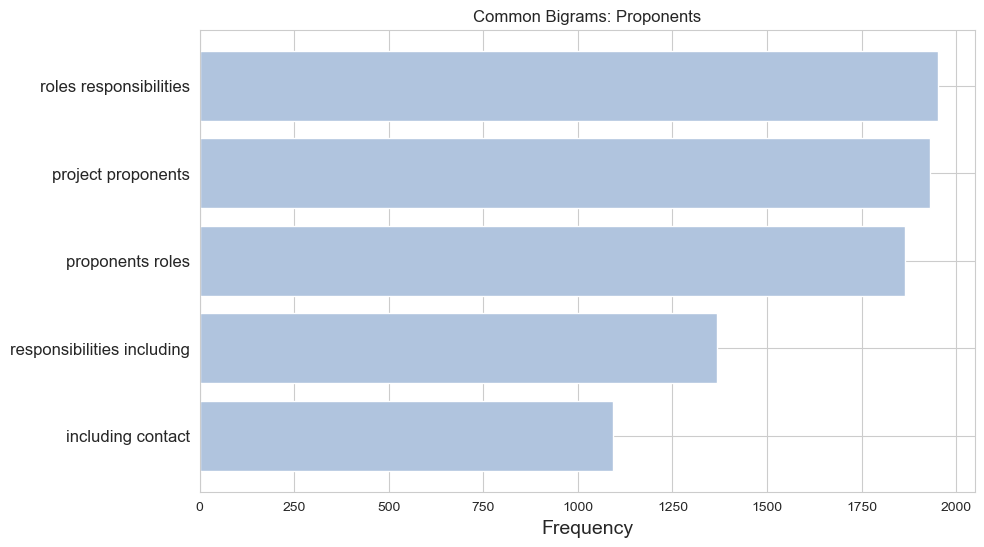

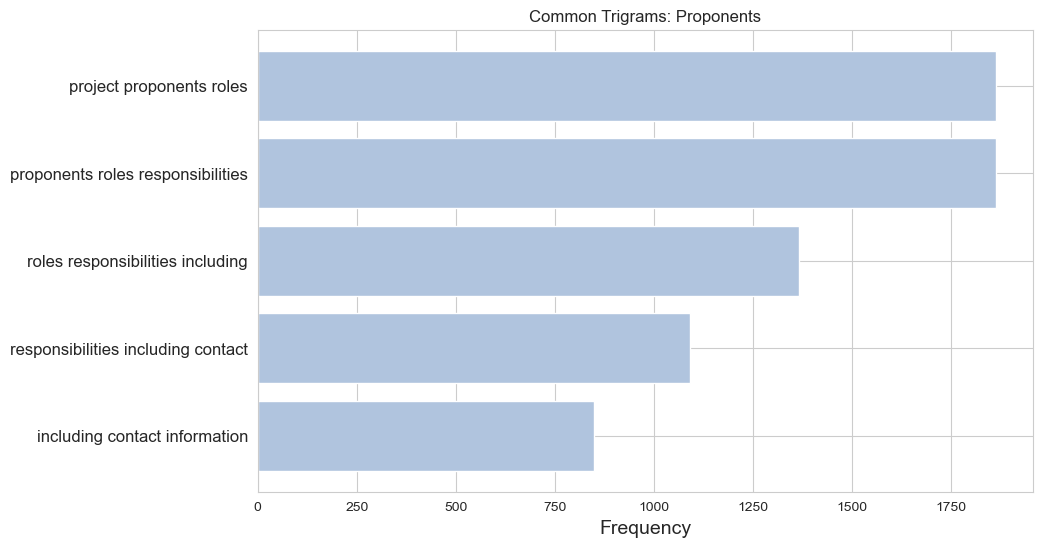

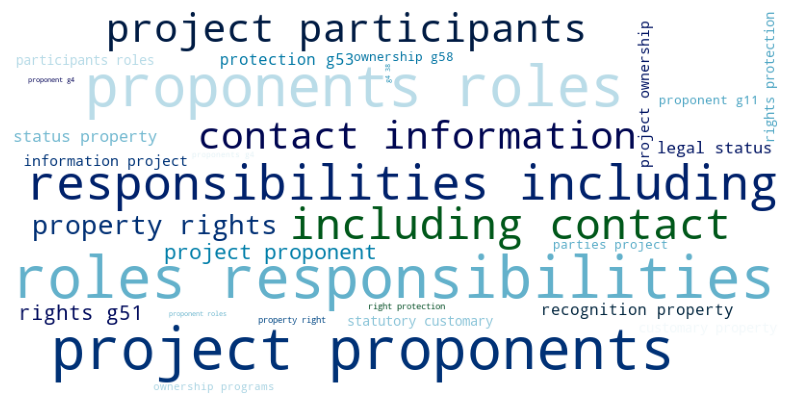

In [56]:
# Filter only focusing category
filtered_df = df[df['Category']=='Project Proponent']

############################
project_proponents = [
    "project proponent",
    "name of person",
    "participants",
    "proof of title",
    "supplier data",
    "carbon offset developer",
    "objective",
    "ownership",
    "property"]
pattern = '|'.join(project_proponents)
filtered_df = filtered_df[filtered_df['heading'].str.lower().str.contains(pattern)]
###############################

# Convert headings to list
headings = filtered_df['heading'].to_list()

# Clean headings by removing punctuation and converting to lowercase
cleaned_headings = [re.sub(r'[^\w\s]', '', heading.lower()) for heading in headings]

# Remove stopwords
processed_headings = [' '.join([word for word in heading.split() if word not in stop_words]) for heading in cleaned_headings]

# Create bi-grams and tri-grams
bigrams = _generate_ngrams(processed_headings, n=2)
trigrams = _generate_ngrams(processed_headings, n=3)

# plot N-grams frequency using bar chart
_plot_ngram_frequencies(bigrams, title="Common Bigrams: Proponents")
_plot_ngram_frequencies(trigrams, title="Common Trigrams: Proponents")

# create wordcloud
_create_wordcloud(bigrams)

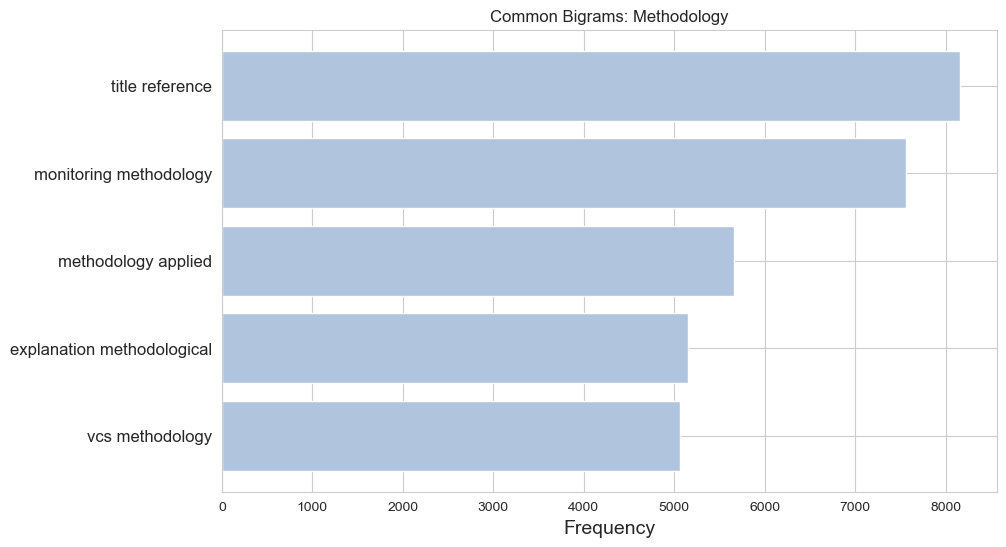

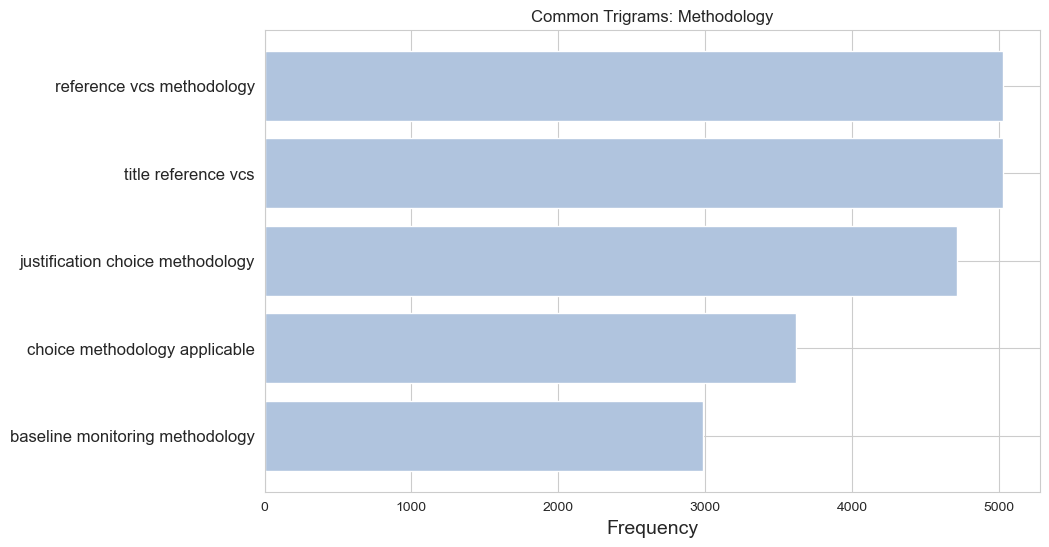

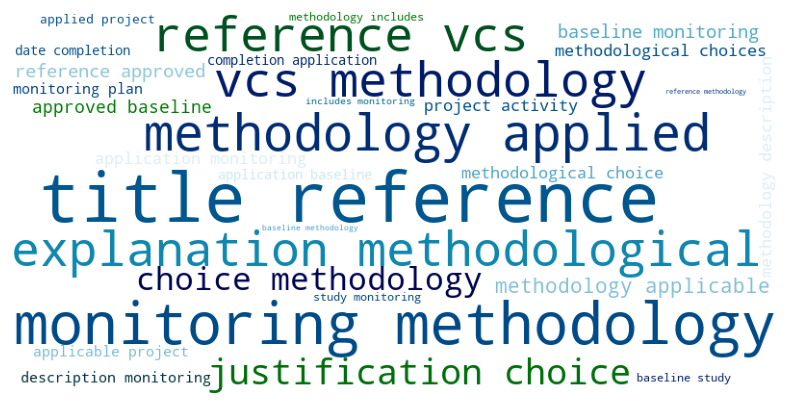

In [57]:
# Filter only focusing category
filtered_df = df[df['Category']=='Methodology']

############################
methodology = ['methodology', 'methodologies','method']
pattern = '|'.join(methodology)
filtered_df = filtered_df[filtered_df['heading'].str.lower().str.contains(pattern)]
############################


# Convert headings to list
headings = filtered_df['heading'].to_list()

# Clean headings by removing punctuation and converting to lowercase
cleaned_headings = [re.sub(r'[^\w\s]', '', heading.lower()) for heading in headings]

# Remove stopwords
processed_headings = [' '.join([word for word in heading.split() if word not in stop_words]) for heading in cleaned_headings]

# Create bi-grams and tri-grams
bigrams = _generate_ngrams(processed_headings, n=2)
trigrams = _generate_ngrams(processed_headings, n=3)

# plot N-grams frequency using bar chart
_plot_ngram_frequencies(bigrams, title="Common Bigrams: Methodology")
_plot_ngram_frequencies(trigrams, title="Common Trigrams: Methodology")

# create wordcloud
_create_wordcloud(bigrams)

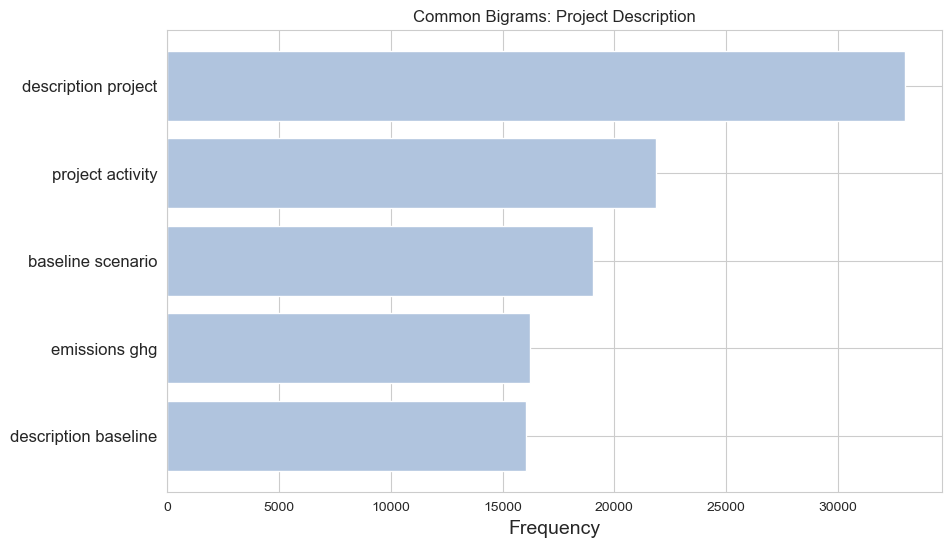

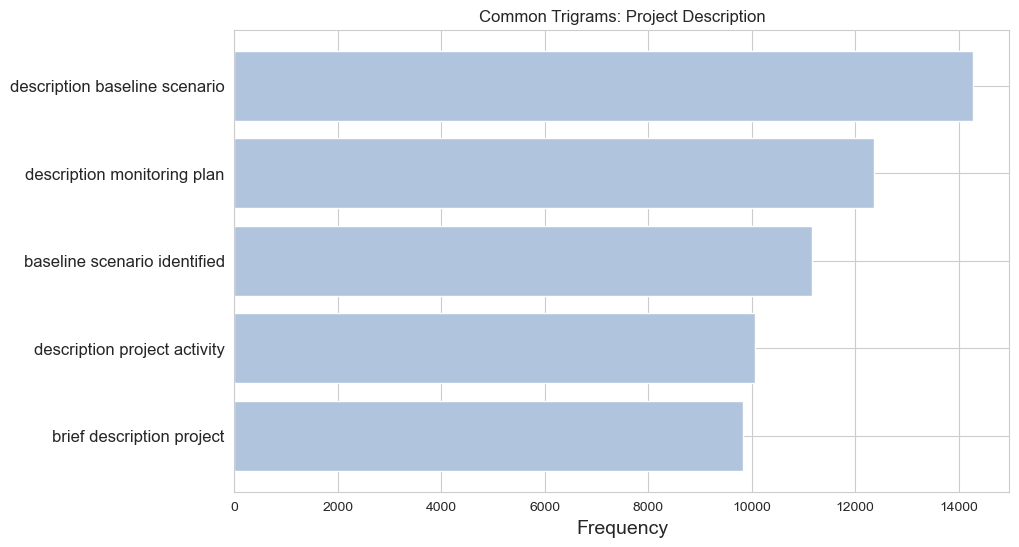

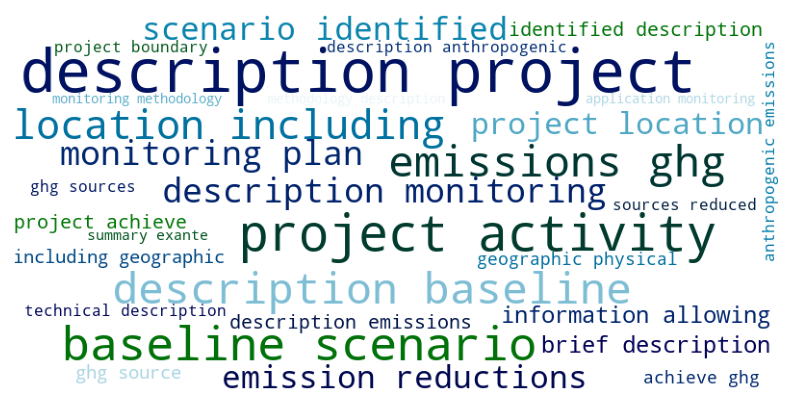

In [58]:
# Filter only focusing category
filtered_df = df[df['Category']=='Project Description']

############################
project_desc = [
        "summary",
        "description",
        "additional information",
        "location",]
pattern = '|'.join(project_desc)
filtered_df = filtered_df[filtered_df['heading'].str.lower().str.contains(pattern)]
############################


# Convert headings to list
headings = filtered_df['heading'].to_list()

# Clean headings by removing punctuation and converting to lowercase
cleaned_headings = [re.sub(r'[^\w\s]', '', heading.lower()) for heading in headings]

# Remove stopwords
processed_headings = [' '.join([word for word in heading.split() if word not in stop_words]) for heading in cleaned_headings]

# Create bi-grams and tri-grams
bigrams = _generate_ngrams(processed_headings, n=2)
trigrams = _generate_ngrams(processed_headings, n=3)

# plot N-grams frequency using bar chart
_plot_ngram_frequencies(bigrams, title="Common Bigrams: Project Description")
_plot_ngram_frequencies(trigrams, title="Common Trigrams: Project Description")

# create wordcloud
_create_wordcloud(bigrams)

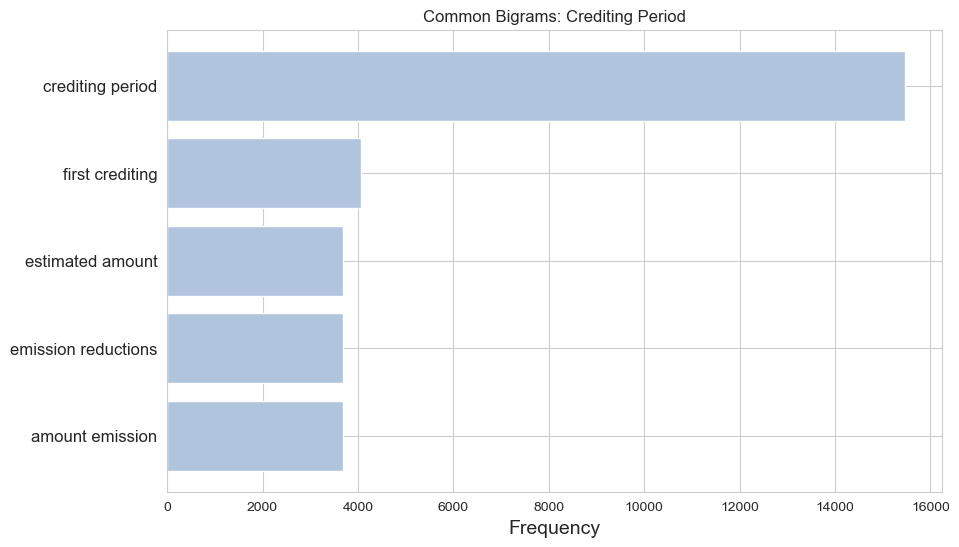

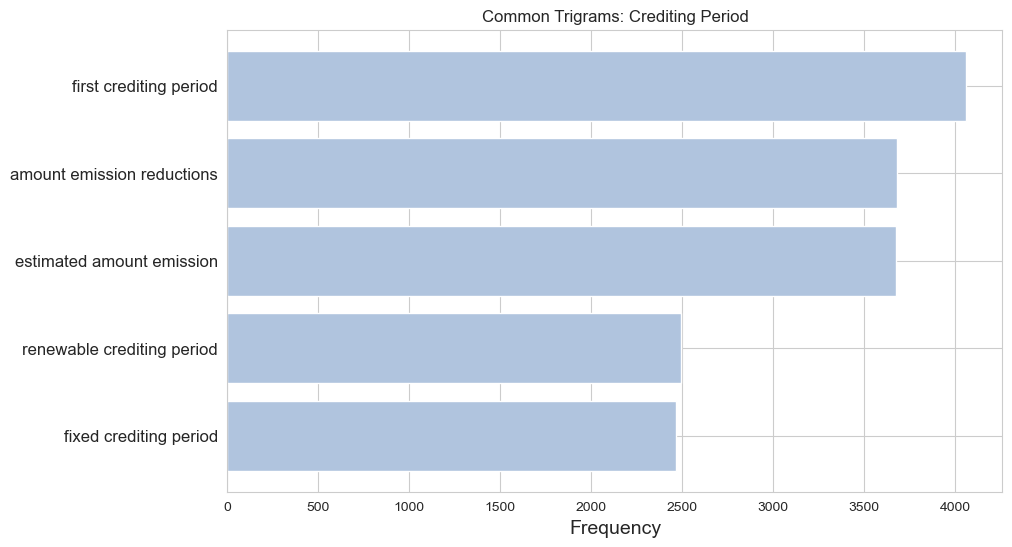

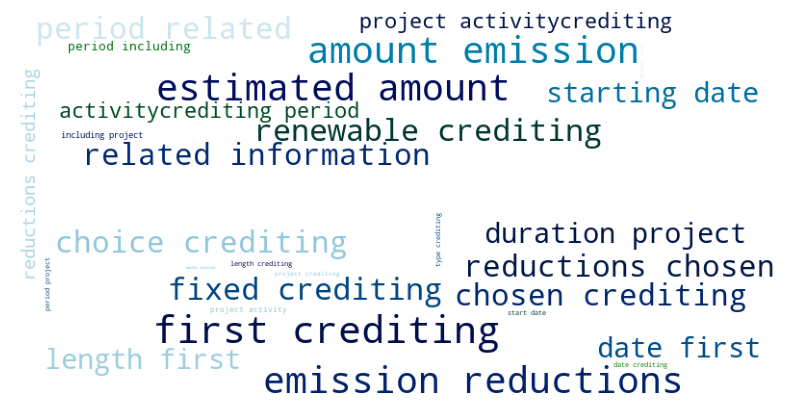

In [59]:
# Filter only focusing category
filtered_df = df[df['Category']=='Credit Period']

############################
credit_period = [
        "crediting period",
        "credit period",
        "crediting"]
pattern = '|'.join(credit_period)
filtered_df = filtered_df[filtered_df['heading'].str.lower().str.contains(pattern)]
############################

# Convert headings to list
headings = filtered_df['heading'].to_list()

# Clean headings by removing punctuation and converting to lowercase
cleaned_headings = [re.sub(r'[^\w\s]', '', heading.lower()) for heading in headings]

# Remove stopwords
processed_headings = [' '.join([word for word in heading.split() if word not in stop_words]) for heading in cleaned_headings]

# Create bi-grams and tri-grams
bigrams = _generate_ngrams(processed_headings, n=2)
trigrams = _generate_ngrams(processed_headings, n=3)

# plot N-grams frequency using bar chart
_plot_ngram_frequencies(bigrams, title="Common Bigrams: Crediting Period")
_plot_ngram_frequencies(trigrams, title="Common Trigrams: Crediting Period")

# create wordcloud
_create_wordcloud(bigrams)

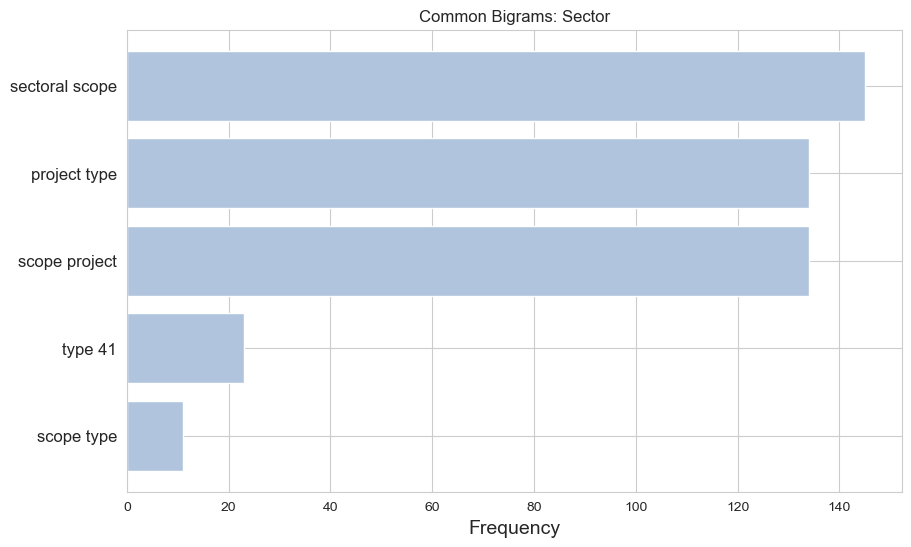

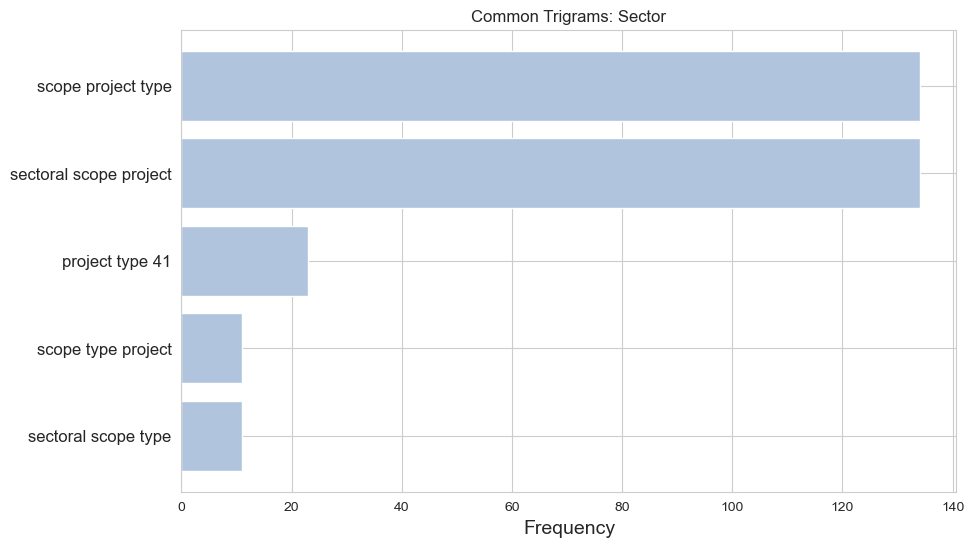

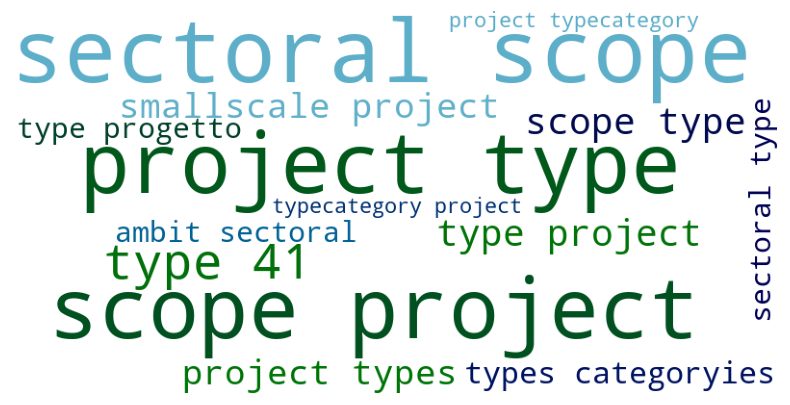

In [60]:
# Filter only focusing category
filtered_df = df[df['Category']=='Sector']

############################
sector = [
        "scope",
        "project type",
        "sectoral",
        "sector"]
pattern = '|'.join(sector)
filtered_df = filtered_df[filtered_df['heading'].str.lower().str.contains(pattern)]
filtered_df = filtered_df[~filtered_df['heading'].str.contains('Central Sector')]
############################

# Convert headings to list
headings = filtered_df['heading'].to_list()

# Clean headings by removing punctuation and converting to lowercase
cleaned_headings = [re.sub(r'[^\w\s]', '', heading.lower()) for heading in headings]

# Remove stopwords
processed_headings = [' '.join([word for word in heading.split() if word not in stop_words]) for heading in cleaned_headings]

# Create bi-grams and tri-grams
bigrams = _generate_ngrams(processed_headings, n=2)
trigrams = _generate_ngrams(processed_headings, n=3)

# plot N-grams frequency using bar chart
_plot_ngram_frequencies(bigrams, title="Common Bigrams: Sector")
_plot_ngram_frequencies(trigrams, title="Common Trigrams: Sector")

# create wordcloud
_create_wordcloud(bigrams)

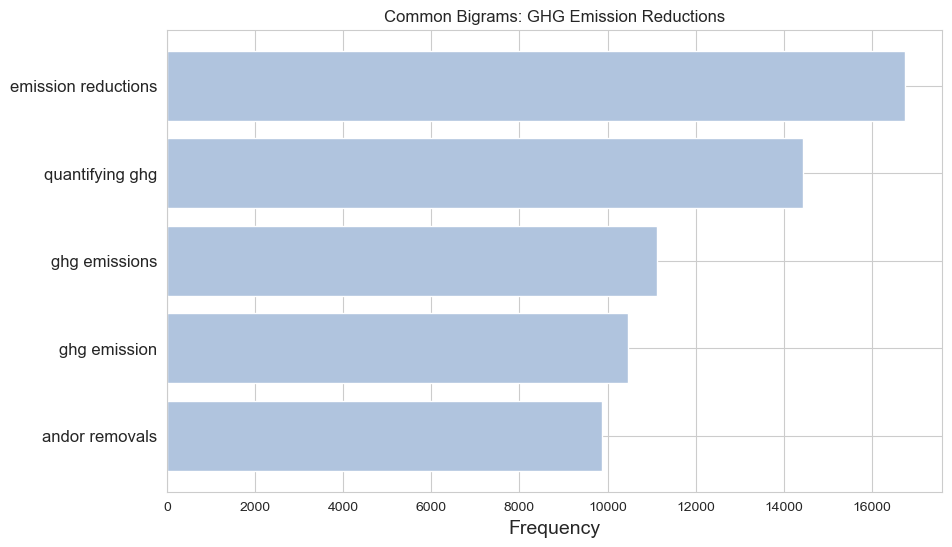

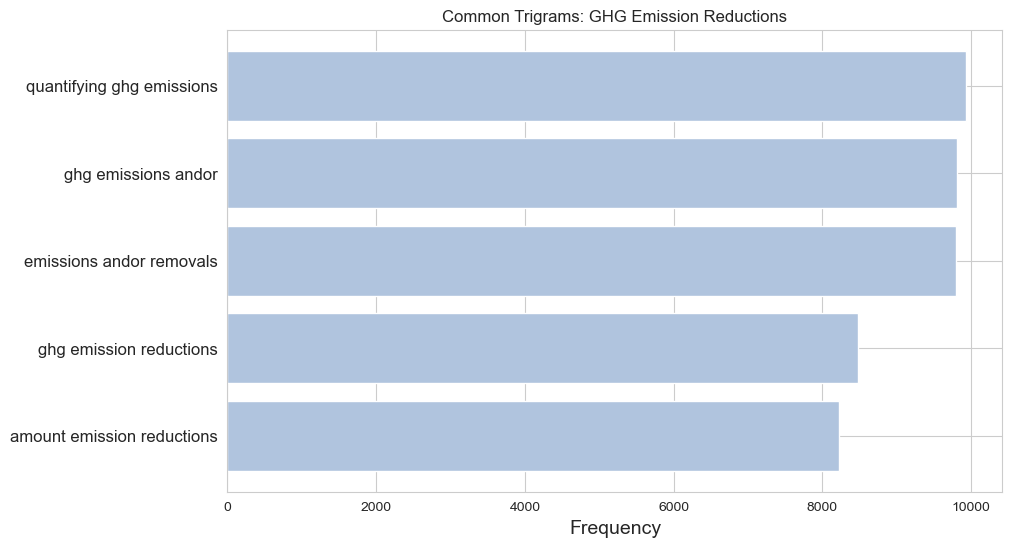

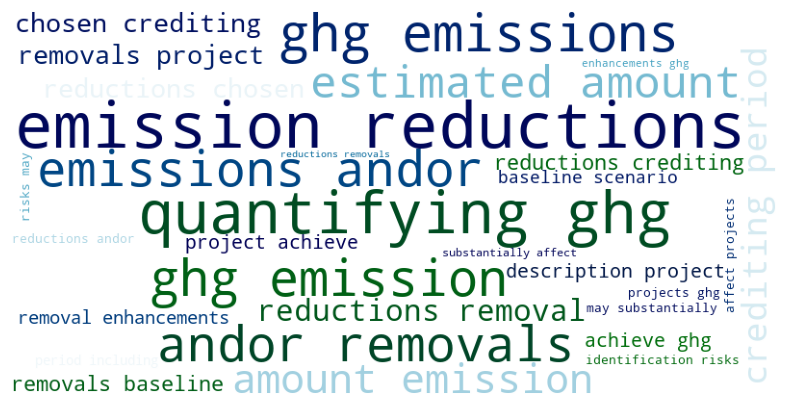

In [61]:
# Filter only focusing category
filtered_df = df[df['Category']=='GHG Emission Reductions']

############################
ghg_emission_reductions = [
        "emission reductduction",
        "greenhouse",
        "ghg emission",
        "greenhousegas",
        "estimated"]
pattern = '|'.join(ghg_emission_reductions)
filtered_df = filtered_df[filtered_df['heading'].str.lower().str.contains(pattern)]
############################

# Convert headings to list
headings = filtered_df['heading'].to_list()

# Clean headings by removing punctuation and converting to lowercase
cleaned_headings = [re.sub(r'[^\w\s]', '', heading.lower()) for heading in headings]

# Remove stopwords
processed_headings = [' '.join([word for word in heading.split() if word not in stop_words]) for heading in cleaned_headings]

# Create bi-grams and tri-grams
bigrams = _generate_ngrams(processed_headings, n=2)
trigrams = _generate_ngrams(processed_headings, n=3)

# plot N-grams frequency using bar chart
_plot_ngram_frequencies(bigrams, title="Common Bigrams: GHG Emission Reductions")
_plot_ngram_frequencies(trigrams, title="Common Trigrams: GHG Emission Reductions")

# create wordcloud
_create_wordcloud(bigrams)

In [62]:
final_variants = {
"project_proponents": ["project proponent", "participants"],
"ghg_emission_reductions": ["ghg emission reduction", "estimated amount of emission reduction"],
"methodology": ["methodology", "methodologies"],
"project_location": ["project location", "location of project", "location of the project", "location of the small-scale project", "project zone map"],
"credit_period": ["crediting period", "credit period"],                                                     
"sector": ["project type", "type of project", "sectoral scope", "sectorial scope", "sector scope", "ambit or sectoral and type of progetto", "category(ies) of project activity", "type and category(ies) and technology/measure of the small-scale project activity", "category of the project"]
}

In [63]:
# Map heading contains specific keyword to defined categories using final variant
toc['matched_section_key'] = toc.apply(_assign_section_key, axis=1, final_variants=final_variants)

In [64]:
filter_df = toc[['section', 'id', 'Project Sector', 'matched_section_key', 'heading', 'original_section']].drop_duplicates(subset=['id', 'matched_section_key'], keep='first')

In [65]:
# Filter only focusing sector
energy_df = filter_df[filter_df['Project Sector']=='Renewable Energy']

# Group data and count number of unique project
agg_data = energy_df.groupby(['matched_section_key', 'section'])['id'].nunique().unstack(fill_value=0)

# Calculate percentages for each section
data = agg_data.div(agg_data.sum(axis=1), axis=0)* 100

# Convert indext to regular column
data.reset_index(inplace=True)

# Reshape data for plotting
data = data.melt(id_vars='matched_section_key', var_name='Section', value_name='percentage').sort_values(by='Section')

# Plot stacked bar chart to visualise section distribution
_plot_stacked_bar_chart(df=data, hue='Section', x_value='percentage', y_value='matched_section_key')

In [66]:
# Filter only focusing sector
forestry_df = filter_df[filter_df['Project Sector']=='Forestry and Land Use']

# Group data and count number of unique project
agg_data = forestry_df.groupby(['matched_section_key', 'section'])['id'].nunique().unstack(fill_value=0)

# Calculate percentages for each section
data = agg_data.div(agg_data.sum(axis=1), axis=0)* 100

# Convert indext to regular column
data.reset_index(inplace=True)

# Reshape data for plotting
data = data.melt(id_vars='matched_section_key', var_name='Section', value_name='percentage').sort_values(by='Section')

# Plot stacked bar chart to visualise section distribution
_plot_stacked_bar_chart(df=data, hue='Section', x_value='percentage', y_value='matched_section_key')

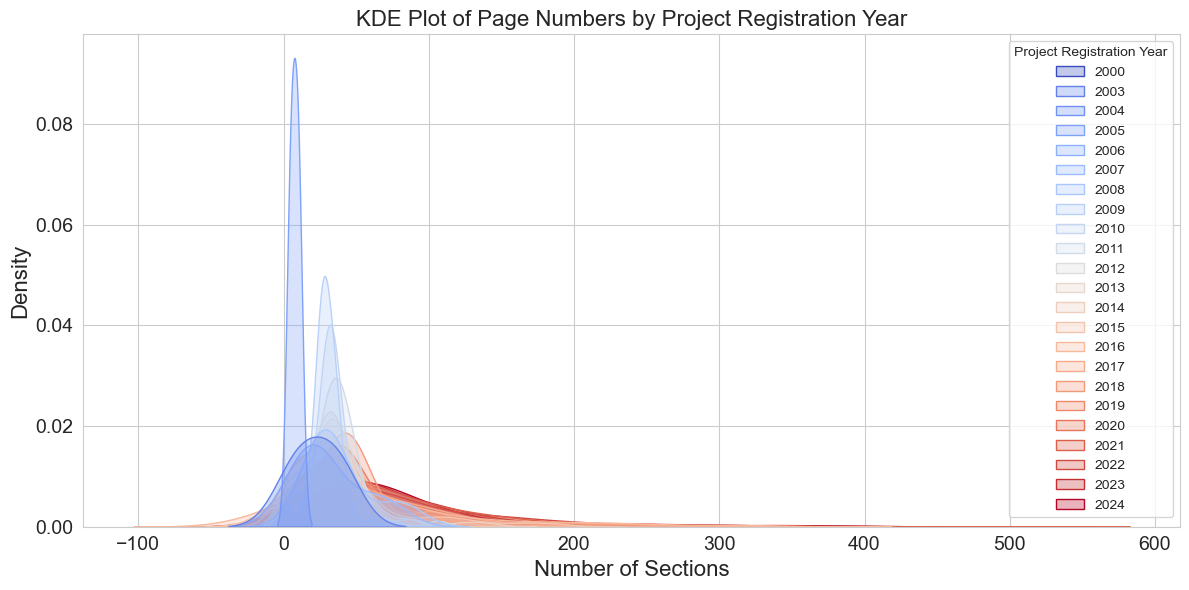

In [67]:
filter_df = toc_project_level[toc_project_level['Project Registration Year'] != 'Not Available']

# KDE Plot by Page number for each year
_plot_kde(filter_df, 'page_number', 'Project Registration Year', 'KDE Plot of Page Numbers by Project Registration Year')

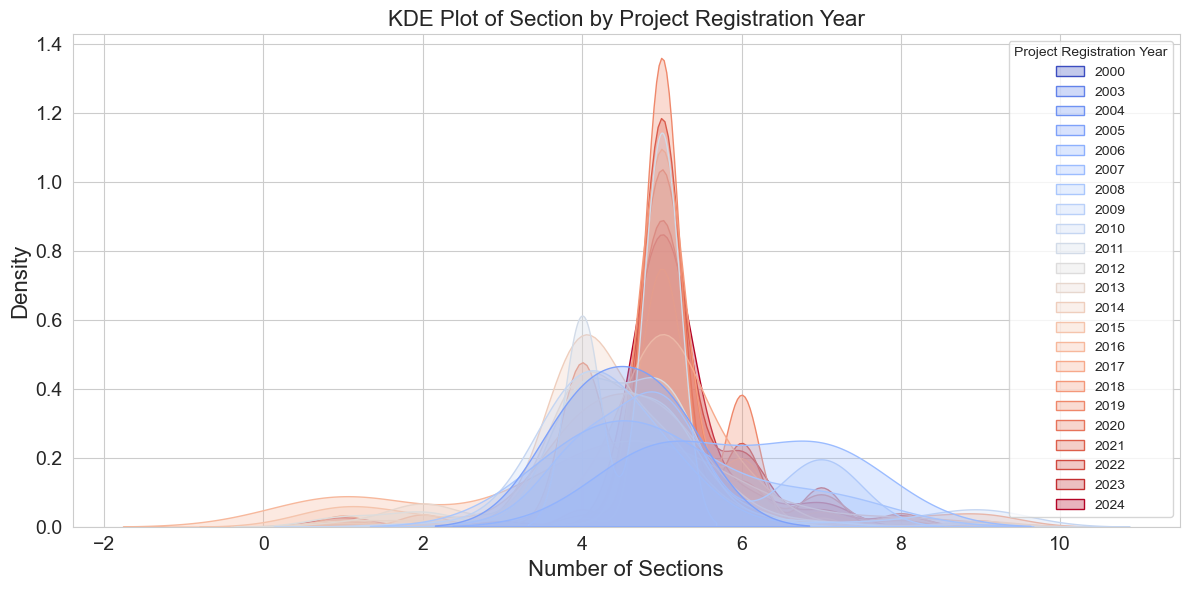

In [68]:
filter_df = toc_project_level[toc_project_level['Project Registration Year'] != 'Not Available']

# KDE Plot by number of sections for each year
_plot_kde(filter_df, 'Number of Sections', 'Project Registration Year', 'KDE Plot of Section by Project Registration Year')

In [69]:
# Create boolean column to check whether section is numerical of alphabetical
filter_df['is_alpha'] = toc['original_section'].apply(lambda x: x.isalpha())

# Group by Project Sector and whether sections are alphabetic or numeric, counting unique ids
grouped_data = filter_df.groupby(['Project Sector', 'is_alpha'])['id'].nunique().unstack(fill_value=0)
grouped_data.columns = ['Numeric Sections', 'Alphabet Sections']

# Reshape for plotting and rename columns
plot_data = grouped_data.reset_index().melt(id_vars='Project Sector', var_name='Section Type', value_name='Project Count')

# Plot vertical stacked bar chart
_plot_stacked_barv_chart(
    df=plot_data,
    hue='Section Type',
    x_value='Project Sector',
    y_value='Project Count',
    color=px.colors.qualitative.G10)

In [70]:
# Filter out row without regisrtation year
filter_df = toc[toc['Project Registration Year'] != 'Not Available']

# Create boolean column to check whether section is numerical of alphabetical
filter_df['is_alpha'] = toc['original_section'].apply(lambda x: x.isalpha())

# Group data and count number of unique projects
grouped_data = filter_df.groupby(['Project Registration Year', 'is_alpha'])['id'].nunique().unstack(fill_value=0)
grouped_data.columns = ['Numeric Sections', 'Alphabet Sections']

# Reshape for plotting and rename columns
plot_data = grouped_data.reset_index().melt(id_vars='Project Registration Year', var_name='Section Type', value_name='Project Count')

# Plot vertical stacked bar chart
_plot_stacked_barv_chart(
    df=plot_data,
    hue='Section Type',
    x_value='Project Registration Year',
    y_value='Project Count',
    color=px.colors.qualitative.G10)

In [71]:
# Count depth level of section such as section 1.2.3 containing 3 levels
filter_df['depth'] = filter_df['section_number'].apply(lambda x: len([part for part in x.split('.') if part]))

# Group data and count number of unique projects
grouped_data = filter_df.groupby(['Project Registration Year', 'depth'])['id'].nunique().unstack(fill_value=0)

# Reshape for plotting and rename columns
plot_data = grouped_data.reset_index().melt(id_vars='Project Registration Year', var_name='Depth Level', value_name='Project Count')

# Plot vertical stacked bar chart
_plot_stacked_barv_chart(
    df=plot_data,
    hue='Depth Level',
    x_value='Project Registration Year',
    y_value='Project Count',
    color=px.colors.qualitative.G10)

### 5. Heading's Keyword Matching Coverage Assessment

In [72]:
toc = pd.read_csv('../../data/training/data_analysis/table_of_contents.csv')

In [73]:
# Predefined keywords in Preliminary Framework
prelim_variants =  {
    "project_proponents": [
        "project proponent",
        "projectpropoonent",
        "promotorul de proiect",
        "proponente del proyecto",
    ],
    "ghg_emission_reductions": [
        "estimated ghg emission reductions",
        "reduceri și eliminări nete de emisii de ges",
    ]}

In [74]:
_coverage_assessment(toc, prelim_variants)

[{'project_proponents': 0.84}, {'ghg_emission_reductions': 0.73}]

In [75]:
# Predefined keywords after the analysis with 338 projects
variants = {
"project_proponents": ["project proponent"],
"ghg_emission_reductions": ["ghg emission reduction"],
"methodology": ["methodology", "methodologies"],
"project_location": ["project location"],
"credit_period": ["crediting period"],
"sector": ["sectoral scope", "project type"]
}

In [76]:
_coverage_assessment(toc, variants)

[{'project_proponents': 0.84},
 {'ghg_emission_reductions': 0.86},
 {'methodology': 0.96},
 {'project_location': 0.77},
 {'credit_period': 0.95},
 {'sector': 0.76}]

In [77]:
final_variants = {
"project_proponents": ["project proponent", "participants"],
"ghg_emission_reductions": ["ghg emission reduction", "estimated amount of emission reduction"],
"methodology": ["methodology", "methodologies"],
"project_location": ["project location", "location of project", "location of the project", "location of the small-scale project", "project zone map"],
"credit_period": ["crediting period", "credit period"],                                                     
"sector": ["project type", "type of project", "sectoral scope", "sectorial scope", "sector scope", "ambit or sectoral and type of progetto", "category(ies) of project activity", "type and category(ies) and technology/measure of the small-scale project activity", "category of the project"]
}

In [78]:
_coverage_assessment(toc, final_variants)

[{'project_proponents': 0.96},
 {'ghg_emission_reductions': 0.96},
 {'methodology': 0.96},
 {'project_location': 0.94},
 {'credit_period': 0.95},
 {'sector': 0.93}]